### Edgar Moises Hernandez-Gonzalez
#### 29/04/20-16/07/20
#### Clasificacion binaria de imagenes motoras en EEG con CNN-2D + LSTM
##### Caracteristicas = Escalogramas CWT (3D)
##### Entrada resize proporcional de 495x500
##### 5 ejecuciones independientes

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pywt
import cv2
from sklearn.metrics import (cohen_kappa_score, confusion_matrix,
                             roc_auc_score, roc_curve)
from keras.models import Sequential
from keras.layers import (TimeDistributed, Conv2D, MaxPool2D, Flatten, LSTM,
                          Dense, Dropout)
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [ ]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [ ]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/MI-EEG-ID-A09T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/MI-EEG-ID-A09E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/Etiquetas-ID-A09T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/Etiquetas-ID-A09E.csv", header=None)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(144, 22000)
(144, 22000)
(144, 1)
(144, 1)


In [ ]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples_train = len(y_train)
n_samples_test = len(y_test)

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 144
n_samples_test : 144


In [ ]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y_test))

print("n_classes:", n_classes)

n_classes: 2


In [ ]:
#unir 22 canales
def unir_escalogramas_vertical(data):
  dim = (500, 495) #ancho, alto
  fs = 250
  escalas = pywt.scale2frequency('cmor3-3', np.arange(8,30.5,0.5)) / (1/fs)
  datos = np.zeros((data.shape[0],495,500))
  temporal = np.zeros((990,1000))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      #sig = sig[124:624]
      # escalograma CWT
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3', sampling_period = (1 / fs))
      temporal[j*45:(j+1)*45, :] = abs(coef)
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [ ]:
#llamar a unir_escalogramas_vertical(data)
inicio = time.time()

x_train = unir_escalogramas_vertical(x_train)
x_test = unir_escalogramas_vertical(x_test)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
0
100
Tiempo: 100.94915843009949


In [ ]:
print(x_train.shape)
print(x_test.shape)

(144, 495, 500)
(144, 495, 500)


In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

76.73492497218665
76.82034745501224
0.012253537662674289
0.01027021693911645
3.48366391025102
3.435095320139737


In [ ]:
x = np.ceil(np.max(x_train))

In [ ]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= x
x_test /= x

In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.9965575
0.9976669
0.00015913685
0.00013337944
0.045242347
0.044611584


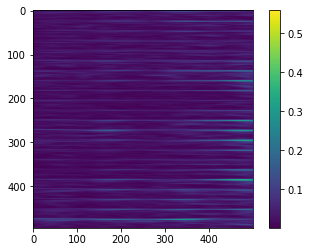

In [ ]:
plt.figure()
plt.imshow(x_train[2])
plt.colorbar()
plt.show()

In [ ]:
#convertir de 3D a 5D
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(144, 1, 495, 500, 1)
(144, 1, 495, 500, 1)


In [ ]:
mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/RNN_CWT_BI_09.hdf5',
                     monitor='val_accuracy', save_best_only=True, verbose=0)

In [ ]:
def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32, activation='tanh', dropout=0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
loss:  0.3422385859820578
accuracy:  0.8888888955116272
kappa:  0.7777777777777778
confusion matrix:
 [[63  9]
 [ 7 65]]
AUC 0.9627700617283951


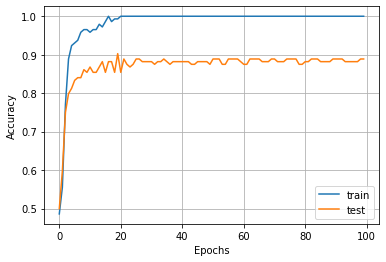

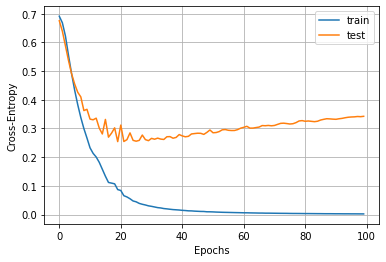

Iteration: 2
loss:  0.3355172293053733
accuracy:  0.8888888955116272
kappa:  0.7777777777777778
confusion matrix:
 [[61 11]
 [ 5 67]]
AUC 0.9652777777777778


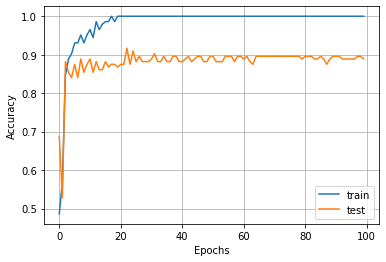

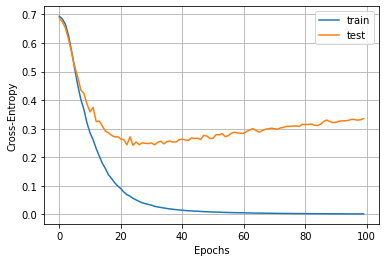

Iteration: 3
loss:  0.3827561289072037
accuracy:  0.8680555820465088
kappa:  0.7361111111111112
confusion matrix:
 [[59 13]
 [ 6 66]]
AUC 0.9618055555555556


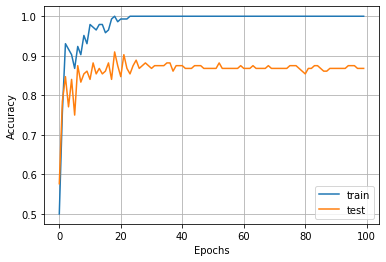

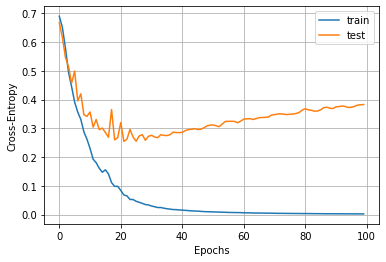

Iteration: 4
loss:  0.32925882190465927
accuracy:  0.9027777910232544
kappa:  0.8055555555555556
confusion matrix:
 [[65  7]
 [ 7 65]]
AUC 0.9635416666666667


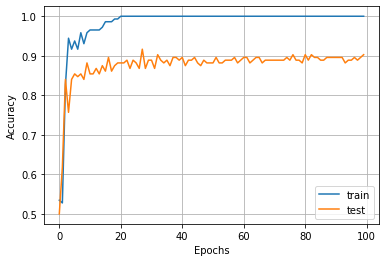

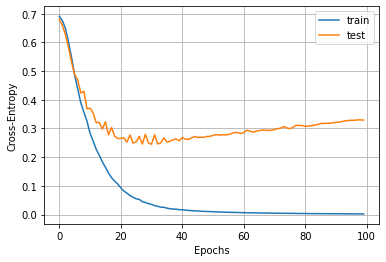

Iteration: 5
loss:  0.3161498366130723
accuracy:  0.8888888955116272
kappa:  0.7777777777777778
confusion matrix:
 [[63  9]
 [ 7 65]]
AUC 0.9631558641975309


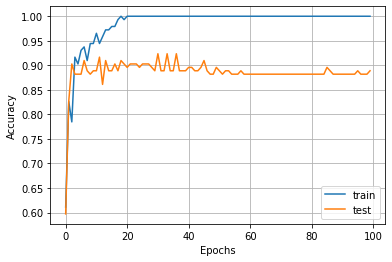

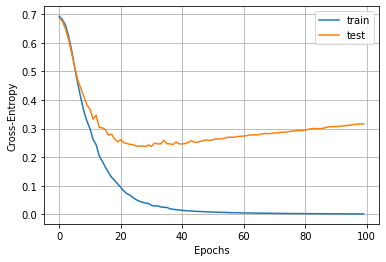


Resultados:
loss: [0.3422385859820578, 0.3355172293053733, 0.3827561289072037, 0.32925882190465927, 0.3161498366130723]
accuracy: [0.8888888955116272, 0.8888888955116272, 0.8680555820465088, 0.9027777910232544, 0.8888888955116272]
kappa: [0.7777777777777778, 0.7777777777777778, 0.7361111111111112, 0.8055555555555556, 0.7777777777777778]
AUC: [0.9627700617283951, 0.9652777777777778, 0.9618055555555556, 0.9635416666666667, 0.9631558641975309]
Tiempo: 431.10646963119507


In [ ]:
inicio = time.time()
array_loss = []
array_acc = []
array_kappa = []
array_auc = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D_LSTM_TD()

  history = model.fit(x_train, y_train, epochs=100, batch_size=36,
                      validation_data=(x_test, y_test), verbose=0,
                      callbacks=[mc])
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  probabilidades = probabilidades[:, 1]
  auc = roc_auc_score(y_test, probabilidades)
  #fpr, tpr, thresholds = roc_curve(y_test, probabilidades)
  array_auc.append(auc)

  print("AUC", auc)
  #plt.plot(fpr, tpr)
  #plt.grid()
  #plt.xlabel('False Positive Rate')
  #plt.ylabel('True Positive Rate')
  #plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
print()
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
print("AUC:", array_auc)
fin = time.time()
tiempo = fin - inicio
print("Tiempo:", tiempo)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, 1, 495, 500, 16)   160       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 1, 247, 250, 16)   0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 1, 247, 250, 16)   2320      
_________________________________________________________________
time_distributed_24 (TimeDis (None, 1, 123, 125, 16)   0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 1, 246000)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                31492224  
_________________________________________________________________
dense_9 (Dense)              (None, 256)              

In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Mean AUC: %.4f" % np.mean(array_auc))
print("std: (+/- %.4f)" % np.std(array_auc))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Max AUC: %.4f" % np.max(array_auc))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.8875
std: (+/- 0.0111)
Mean Kappa: 0.7750
std: (+/- 0.0222)
Mean AUC: 0.9633
std: (+/- 0.0011)
Max Accuracy: 0.9028
Max Kappa: 0.8056
Max AUC: 0.9653
Tiempo: 431


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jul 17 03:02:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    43W /  70W |   8799MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------